# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
pip install pandas_profiling

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Загрузим необходимые библиотеки
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from lightgbm import LGBMRegressor



/tmp/ipykernel_781/3194538453.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [3]:
# Сохраним датафрейм 
data=pd.read_csv('/datasets/autos.csv')

In [4]:
# Просмотрим информацию
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Проведем небольшую предобработку данных. 

In [6]:
# Ищем пропуски
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
# Проверяем дубликаты
data.duplicated().sum()

4

In [8]:
# Удалим дубликаты
data = data.drop_duplicates(keep='first')
data = data.reset_index(drop=True)

# Проверяем 
data.duplicated().sum()

0

На первом этапе изучения данных мы видим, что можно поменять названия колонок на нижний регистр, для правильного вида. Также изменить тип данных на колонках с датами и временем. В датафрейме присутствуют дубликаты и пропуски. От дубликатов можно избавиться, так как их небольшое кол-во, а вот пропуски пока не будем удалять, разберемся с ними поконкретнее.

In [9]:
# Изменим названия колонок
data=data.rename(columns={'DateCrawled':'Date_Crawled', 'VehicleType':'Vehicle_Type',
                          'RegistrationYear':'Registration_Year', 'RegistrationMonth':'Registration_Month', 
                          'FuelType':'Fuel_Type', 'DateCreated':'Date_Created', 'NumberOfPictures':'Number_Of_Pictures',
                          'PostalCode':'Postal_Code', 'LastSeen':'Last_Seen'})
# Приведем все к нижнему регистру
data.columns=data.columns.str.lower()

# Поменяем тип данных
data['date_crawled']=pd.to_datetime(data['date_crawled'])
data['date_created']=pd.to_datetime(data['date_created'])
data['last_seen']= pd.to_datetime(data['last_seen'])
# Проверим
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   354365 non-null  int64         
 4   gearbox             334532 non-null  object        
 5   power               354365 non-null  int64         
 6   model               334660 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           321470 non-null  object        
 10  brand               354365 non-null  object        
 11  repaired            283211 non-null  object        
 12  date_created        354365 non-null  datetime64[ns]
 13  number_of_pictures  354365 no

Итак, просмотрим наши данные.

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

Такие данные, как дата скачивания анкеты, месяц регистрации авто( нам хватит и года), почтовый индекс владельца, дата создания анкеты, кол-во фотографий авто и дата последней активности пользователя,не являются для нашей модели информативными, так что можем смело избавиться от них.

In [10]:
# Удалим неинформативные столбцы

data=data.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

In [11]:
# Посмотрим теперь на наличие пропусков в каждой колонке
data.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

In [12]:
# Посмотрим в колонках с пропусками какие есть значения
for i in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']:
    print(i)
    print('-'*10)
    print(data[i].value_counts(dropna=False))
    print()
    print(f'кол-во NaN',data[i].isna().sum(),'---- ', f'процент NaN',
          round(data[i].isna().sum()/len(data)*100, 2),'%')
    print()



vehicle_type
----------
sedan          91457
small          79830
wagon          65165
NaN            37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

кол-во NaN 37490 ----  процент NaN 10.58 %

gearbox
----------
manual    268249
auto       66283
NaN        19833
Name: gearbox, dtype: int64

кол-во NaN 19833 ----  процент NaN 5.6 %

model
----------
golf                  29232
other                 24420
3er                   19761
NaN                   19705
polo                  13066
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 251, dtype: int64

кол-во NaN 19705 ----  процент NaN 5.56 %

fuel_type
----------
petrol      216349
gasoline     98719
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electr

Кол-во пропусков достаточно большое, в одном только столбце repaired их 20% от всего датафрейма. Но есть и такие, где процент всего 5,5%. Такие данные можно удалить. В остальных случаях, надо либо заполнять пропуски, что мы не можем сделать, либо ставить заглушку. Мы поставим везде заглушку, чтобы в дальнейшем не было проблем с обучением. Заполнять пропуски мы не будем, так как не владеем необходимой нам специализированной информацией для этого, а заполнять случайными значениями категорически нельзя, потому что данная информация влияет на стоимость машины. 

In [13]:
# Заполним пропуски заглушкой other
for i in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']:
    data[i]=data[i].fillna('other')
    
data.isna().sum()    

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Пропуски заполненны, можно двигаться дальше.

<div class="alert alert-info">
<b>Комментарий студента</b>

Привет Александр! отдельное тебе ОГРОМНОЕ спасибо за это разъяснение про пропуски. У нас вечный спор всегда из-за них, но твое эссе хоть логику поселило в мою голову)
</div>

In [14]:
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

После просмотра профайла, стала заметна несколько  деталей, а именно:
- цена - есть нулевые значения 
- мощность автомобиля - много нулевых значений и явно нереальные цифры в максимумах
- год регистрации авто - нереалистичные года

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='power'>

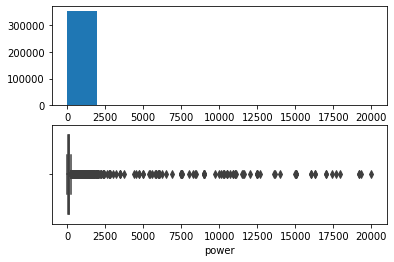

In [15]:
# Рассмотрим мощность еще раз
plt.subplot(2,1,1)
plt.hist(x=data['power'],bins=10)
plt.subplot(2,1,2)
sns.boxplot(data['power'])


In [16]:
# Найдем процент нулей в столбце мощности
data[data['power'] == 0]['price'].count() / data.shape[0] * 100

11.351290336235238

Что мы видим, 11% нулей в графе мощность. Это явные выбросы. Причину такого некорректного заполнения данных можно найти в человеческом факторе, или в сбое программы. 11% это достаточно большое значение, чтобы просто удалить, но лучше от этого избавиться для обучения.

Также есть максимальные значения 20000, что не может быть правдой. Даже в топ-10 самых мощных авто вошли машины с мощностью всего лишь 2500-5000 л.с. Возмжно, неправильно стоит запятая, но этих значений не так много, так что проще удалить. Мы поставим ограничение 500, судя по маркам автомобилей и их моделям, тут нет супер мощных авто, так что этого значения будет более чем достаточно. А минимальное возьмем значение 50 л.с. Хоть и существуют автомобили, где мощность равна 13 л.с., но в данной анкете они отсутствуют точно. 

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='power'>

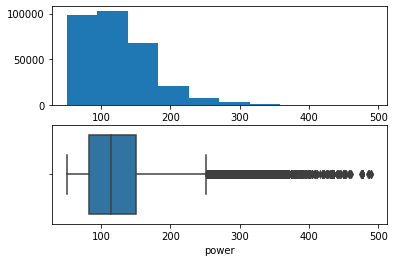

In [17]:
# Удалим выбросы
data=data.query('50 < power < 500')

# Проверим
plt.subplot(2,1,1)
plt.hist(x=data['power'],bins=10)
plt.subplot(2,1,2)
sns.boxplot(data['power'])


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

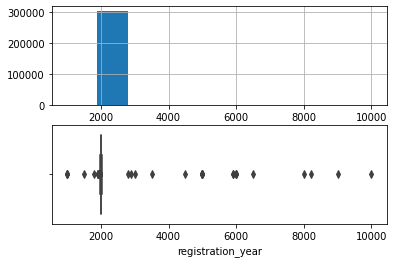

In [18]:
# Теперь посмотрим на год регистарции авто
plt.subplot(2,1,1)
data['registration_year'].hist(bins=10)
plt.subplot(2,1,2)
sns.boxplot(data['registration_year'])
plt.show

Что у нас имеется, много выбросов. Будем от них избавляться. Посмотрим, какие у нас имеются значения.

In [19]:
data['registration_year'].unique()

array([2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2016, 2007, 2009,
       2002, 2018, 1990, 2017, 2003, 1991, 1984, 2006, 1999, 2012, 1994,
       2010, 2000, 1992, 1997, 2013, 1996, 1989, 2015, 1993, 1985, 1983,
       1981, 1969, 1971, 1987, 1973, 1988, 1980, 1986, 1965, 1974, 1982,
       1978, 1976, 1979, 1972, 1977, 1961, 1970, 1968, 1963, 1966, 1954,
       1975, 1959, 1941, 1500, 1960, 1910, 1967, 1949, 1953, 2019, 1958,
       1962, 2900, 6000, 1964, 5911, 1955, 8000, 1956, 1951, 1950, 5000,
       1942, 1935, 3000, 6500, 1957, 9999, 1000, 1952, 1930, 1943, 9000,
       1800, 2800, 1948, 4500, 1937, 8200, 1947, 3500])

Так как анкета у нас по 2016 год, то и остальные года мы можем смело отбрасывать( а именно, машины "будущего"). С минимальным порогом чуть сложнее. Хоть и существуют раритеные автомобили, но мы не уверены,что они присутсвуют в данной анкете. Джае если это так, то мы рискнем, и поставим минимальный порог 1950 год.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

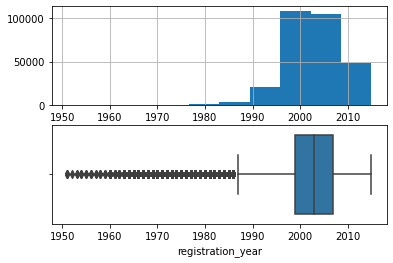

In [20]:
# Удалим ненужные года
data = data.query('1950 < registration_year < 2016')

# Проверяем
plt.subplot(2,1,1)
data['registration_year'].hist(bins=10)
plt.subplot(2,1,2)
sns.boxplot(data['registration_year'])
plt.show

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

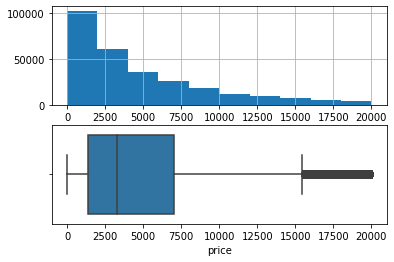

In [21]:
# Теперь проверим наш целевой признак-цена
plt.subplot(2,1,1)
data['price'].hist(bins=10)
plt.subplot(2,1,2)
sns.boxplot(data['price'])
plt.show

In [22]:
# Посмотрим, сколько % нулей имеется
data[data['price'] == 0]['price'].count() / data.shape[0] * 100

1.979098263311584

Всего 1% машин отдают бесплатно. Но все равно, такие данные вызывают вопросы, на которые нам могут дать ответ только представители данного сервиса... Удалим эти показатели

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

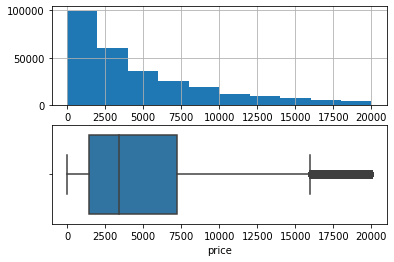

In [23]:
data = data[data['price'] !=0]

# Посмотрим на наши изменения
plt.subplot(2,1,1)
data['price'].hist(bins=10)
plt.subplot(2,1,2)
sns.boxplot(data['price'])
plt.show

**Вывод**. В представленных нам данных было обнаружено много пропусков, которые мы,  к сожалению, не можем заполнить ничем, кроме "заглушко". Дубликаты имелись, но не значительное кол-во, так что их удалили. Также были выявлены аномальные значения в колонках цена, мощность и год регистрации авто. От аномалий также успешно избавились. Почему случились такие некорректные заполнения данных, мы сказать точно не можем, возможно проблема с сайтом, возможно человеческий фактор, но эти проблемы желательно решить( процент неккоректных данных достаточно большой).  
Сильной корреляции не наблюдается между признаками и целевым признаком, но есть слабая зависимость цены от мощности,года регистрации и пробега. 

## Обучение моделей

Мы выберем 3 модели для обучения. Это LightGBM, CatBoost и LinearRegression( добавили Random Forest). Для моделей мы сделаем перекодировку, то есть категориальные признаки перекодируем в числовые. Эту операцию проделаем с помощью метода OHE, так как он самый универсальный. Для проверки качества моделей будем применять метрику и опираться будем на значения  RMSE < 2500.

Для подбора лучших параметров будем использовать кросс-валидацию через GridSearchCV

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280626 entries, 1 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              280626 non-null  int64 
 1   vehicle_type       280626 non-null  object
 2   registration_year  280626 non-null  int64 
 3   gearbox            280626 non-null  object
 4   power              280626 non-null  int64 
 5   model              280626 non-null  object
 6   kilometer          280626 non-null  int64 
 7   fuel_type          280626 non-null  object
 8   brand              280626 non-null  object
 9   repaired           280626 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.6+ MB


In [25]:
# Очень много данных в колонке Модель. Возможно, на цену это сильно повлияет, но для обучения это много лишнего.
data=data.drop(['model'], axis=1)

In [26]:
# Разделим на категориальные признаки и числовые
category_features = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']
numeric = ['registration_year', 'power', 'kilometer']

# Выделим признаки и целевой признак
features=data.drop(['price'], axis=1)
target=data['price']

# готовим наши выборки
RANDOM_STATE=12345

features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.25, random_state=RANDOM_STATE)

print('Target test count = {}, Train test count = {}'.format(target_test.shape, target_train.shape))   

Target test count = (70157,), Train test count = (210469,)


In [27]:
# С помощью функции сразу проведем кодирование методом ОНЕ и масштабирование
col_transformer_ohe = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='error', drop='first', sparse=False),
        make_column_selector(dtype_include=object),
    ),
    (
        StandardScaler(),
        make_column_selector(dtype_include='number'),
    ),

    remainder='passthrough',
)

In [28]:
# Закончим
features_train_ohe = pd.DataFrame(col_transformer_ohe.fit_transform(features_train))
features_test_ohe = pd.DataFrame(col_transformer_ohe.transform(features_test))

In [29]:
# Напишем функцию для подсчета RMSE
def rmse(target, predicted):
    return mean_squared_error(target, predicted) ** 0.5

Перейдем к обучению. Начнем с простых моделей, таких как Случайный лес и Линейная Регрессия. 

In [30]:
%%time

RMSE = 'neg_mean_squared_error'
cv = 3

# Попробуем обучить случайный лес
parameters = {'n_estimators': range(5,11,5),'max_depth': range(1,8,3), 'min_samples_leaf': range(1,5,2),
              'min_samples_split': range(2,6,2)}

model = RandomForestRegressor()

grid = GridSearchCV(model, parameters, cv=cv, scoring=RMSE)
grid.fit(features_train_ohe, target_train)

grid.best_params_



CPU times: user 2min 36s, sys: 2.9 s, total: 2min 39s
Wall time: 2min 39s


{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

In [31]:
# Чтобы не собирать вручную результаты, напишем класс, который будет сохранять время обучения, время предсказания и RMSE

import time

class ModelHelper:
    def __init__(self, name, model):
        self.name = name
        self.model = model
    
    def fit(self, features, target):
        start = time.time()    
        self.model.fit(features, target)
        end = time.time() - start
        self.fitTime = end
    
    def predict(self, features, target):
        start = time.time()  
        predicted = self.model.predict(features)
        end = time.time() - start
        self.predictedTime = end
        self.rmse = rmse(target, predicted)
    
    def getResult(self):
        return self.name, self.fitTime, self.predictedTime, self.rmse

In [32]:
# Создадим переменную, где будут храниться результаты
result = []

# И создадим функцию для красивого вывода
def print_result(result):
    print('|{: >20}|{: >18}|{: >18}|{: >12}|'.format('Модель', 'Время обучения', 'Время предсказания', 'RMSE'))
    for info in result:
        print('|{: >20}|{: >18.5f}|{: >18.5f}|{: >12.5f}|'.format(info[0], info[1], info[2], info[3]))

In [33]:
# Проверим наш случайный лес
model_forest = grid.best_estimator_
model_forest_helper = ModelHelper('Random forest', model_forest)
model_forest_helper.fit(features_train_ohe, target_train)
model_forest_helper.predict(features_train_ohe, target_train)
result.append(model_forest_helper.getResult())

In [34]:
# Попробуем линейную регрессию
model_lr = LinearRegression()
model_lr_helper = ModelHelper('Linear regression', model_lr)
model_lr_helper.fit(features_train_ohe, target_train)
model_lr_helper.predict(features_train_ohe, target_train)
result.append(model_lr_helper.getResult())

In [35]:
# Посмотрим на промежуточный результат
print_result(result)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|       Random forest|           7.23896|           0.16354|  2113.74756|
|   Linear regression|           3.27026|           0.20084|  2676.50294|


**Промежуточный вывод**. По результатам обучения простых моделей можно сказать, что быстрее обучает модель Случайный Лес и по метрике RMSE  она лучше, чем модель Линейная Регрессия.

**LightGBM** Теперь перейдем к моделям бустинга. Начнем с LightGBM. Для него также, как и для простых моделей, нужно поменять категориальные признаки на числовые.  

In [36]:
pd.options.mode.chained_assignment = None

# Подготовим заново признаки для бустинга
features_lgbm = data.drop(columns='price')
target_lgbm = data['price']

# Разделим выборку на обучающую и тестовую
features_train_2, features_test_2, target_train_2, target_test_2 = train_test_split(
        features_lgbm, target_lgbm, test_size=0.25, random_state=RANDOM_STATE)

# Проведем скалирование
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train_2[numeric] = scaler.transform(features_train_2[numeric])
features_test_2[numeric] = scaler.transform(features_test_2[numeric])

# Посмотрим, что вышло
features_train_2.head()

,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired
117487,coupe,-0.128895,manual,-0.143104,0.592760,petrol,bmw,other
337055,bus,0.701160,manual,-0.543736,0.592760,petrol,mercedes_benz,no
33358,convertible,0.867171,manual,0.314760,-0.089816,petrol,opel,no
322859,convertible,0.203127,manual,0.887090,0.592760,petrol,bmw,other
22997,sedan,0.535149,manual,2.699470,0.592760,petrol,bmw,no


In [37]:
# Для GBM дополнительно обработаем категориальные признаки

features_train_gbm = features_train_2.copy()
features_test_gbm = features_test_2.copy()

category_features_gbm = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']

encoder = OrdinalEncoder()
encoder.fit(features_train_gbm[category_features_gbm])
features_train_gbm[category_features_gbm] = encoder.transform(features_train_gbm[category_features_gbm])
features_test_gbm[category_features_gbm] = encoder.transform(features_test_gbm[category_features_gbm])

features_train_gbm.head()

,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired
117487,2.0,-0.128895,1.0,-0.143104,0.592760,6.0,2.0,1.0
337055,0.0,0.701160,1.0,-0.543736,0.592760,6.0,20.0,0.0
33358,1.0,0.867171,1.0,0.314760,-0.089816,6.0,24.0,0.0
322859,1.0,0.203127,1.0,0.887090,0.592760,6.0,2.0,1.0
22997,4.0,0.535149,1.0,2.699470,0.592760,6.0,2.0,0.0


In [38]:
#%%time

#gbm = LGBMRegressor(boosting_type='gbdt', seed=RANDOM_STATE)
#gbm_params = {'learning_rate': [0.1], 'n_estimators': [60], 'max_depth': [4,6]}

#grid_gbm = GridSearchCV(gbm, gbm_params, cv=cv, scoring=RMSE)
#grid_gbm.fit(features_train_gbm, target_train_2);

#grid_gbm.best_params_

In [39]:
#CPU times: user 5h 52min 19s, sys: 2min 38s, total: 5h 54min 58s
#Wall time: 5h 57min 48s
#{'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 40}


# Очень много времени ушло, в первом прогоне было 2 часа

In [41]:
# Посмотрим, что получилось в итоге
model_gbm = LGBMRegressor(boosting_type='gbdt', seed=RANDOM_STATE, n_estimators = 60, max_depth = 5)
model_gbm_helper = ModelHelper('LightGBM', model_gbm)
model_gbm_helper.fit(features_train_gbm, target_train)
model_gbm_helper.predict(features_test_gbm, target_test)
result.append(model_gbm_helper.getResult())

In [42]:
print_result(result)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|       Random forest|           7.23896|           0.16354|  2113.74756|
|   Linear regression|           3.27026|           0.20084|  2676.50294|
|            LightGBM|         162.96370|           0.29027|  1785.45141|


 **CatBoost** Перейдем к бустингу, а именно модели  CatBoost. Для нее не требуется специальная перекодировка категориальных признаков, так что мы используем обычные выборки.

In [43]:
#%%time
#for model in models: 
#    start_time = time.time()
#    cv_score = cross_val_score(cat_model, 
#                               features_train_2, 
#                               target_train_2, 
#                               cv=cv, 
#                               scoring=RMSE,
#                               n_jobs=-1).mean()    
    
#    elapsed_time = time.time() - start_time
#    results_cross_val_0.append({'model_name': model.__class__.__name__, 
#                              'cross_val_score': int(cv_score),
#                              'learn_time': int(elapsed_time)}) 

**Вывод** Так как у нас возникли небольшие проблемы с одной из моделей, придется анализировать только те, что у нас сработали. Простые модели Случайный лес и Линейная Регрессия сработали быстро, но не достаточно хорошо. Хоть метрика RMSE и показала у модели Случайный лес допустимый результат, но модель бустинга LightGBM , в этом плане, сработала лучше. 
Если смотреть такой параметр как время, то в нашем варианте, конечно, бустинг проигрывает. 

## Анализ моделей

Так как у нас по времени бустинг обучается очень долго, то возьмем для проверки на тестовой выборке простую модель Случайный лес

In [ ]:
#model_forest_test = grid.best_estimator_
#model_forest_helper_test = ModelHelper('Random forest', model_forest_test)
#model_forest_helper_test.fit(features_test_ohe, target_test)
#model_forest_helper_test.predict(features_test_ohe, target_test)
#result.append(model_forest_helper_test.getResult())

Проверим все таки наш бустинг 

In [44]:
model_gbm = LGBMRegressor(boosting_type='gbdt', seed=RANDOM_STATE, n_estimators = 60, max_depth = 5)
model_gbm_helper = ModelHelper('LightGBM', model_gbm)
model_gbm_helper.fit(features_test_gbm, target_test)
model_gbm_helper.predict(features_test_gbm, target_test)
result.append(model_gbm_helper.getResult())

In [45]:
print_result(result)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|       Random forest|           7.23896|           0.16354|  2113.74756|
|   Linear regression|           3.27026|           0.20084|  2676.50294|
|            LightGBM|         162.96370|           0.29027|  1785.45141|
|            LightGBM|         170.32155|           0.38254|  1755.23865|


**ВЫВОД** Итак, данные были очень *грязные*, пришлось многое отбрасывать, заменять пропуски, убирать нули, в итоге мы пришли к более-менее подготовленному датафрейму. Для обучения мы выбрали 4( на самом деле 3) модели: Random forest, Linear regression, LightGBM и CatBoost( не сработал(((). Простые модели обучались очень быстро, но результат все равно оставляет желать лучшего, хотя границ мы не нарушили ( RMSE< 2500). Лучший результат показала модель LightGBM (RMSE = 1785), но время на обучение потратила очень много. Мы уверенны, что если бы именно эту модель мы испытали на тестовой выборке, то результаты были бы еще лучше, но из-за нехватки времени, на тестовой выборке мы испытали модель Случайный лес. Результат стал немного лучше и также не нарушая лимит метрики.